In [2]:
import gym
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('ggplot')


%matplotlib inline

In [4]:
env=gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [83]:
# settings

state_size=env.observation_space.shape[0]
action_size=env.action_space.n
POLICYAPP_LEARNING_RATE=0.01
VALUE_LEARNING_RATE=0.0001

discount_factor=.99

### 2 hidden layers (10,2) units , 1 Output layer (2) units

In [66]:
class PolicyApproximator:
    
    def __init__(self):
        
        # Tensorflow settings

        tf.reset_default_graph()
        
        # Building the Network
        
        self.states=tf.placeholder(name='states',shape=[None,state_size],dtype=tf.float32)
        self.actions=tf.placeholder(name='actions',shape=[None,action_size],dtype=tf.float32) # int32 because they are discrete actions.
        
        self.targets=tf.placeholder(name='targets',shape=[None,1],dtype=tf.float32)
        
        self.layer1=tf.layers.dense(activation=tf.nn.relu,units=8,inputs=self.states)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.layer2=tf.layers.dense(activation=tf.nn.relu,units=2,inputs=self.layer1)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        self.output=tf.layers.dense(activation=None,units=action_size,inputs=self.layer2)#,kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        self.actions_probabilites=tf.nn.softmax(self.output)
        
        #self.action_probability=tf.maximum(self.actions_probabilites)
        #self.selected_action_probability=tf.gather_nd(self.actions_probabilites,self.actions)
        
        self.good_probabilites=tf.reduce_sum(self.actions_probabilites*self.actions,axis=1)

       # self.log=tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.actions_layer,labels=self.actions)
        #self.loss=tf.reduce_mean(self.log*self.discounted_reward)
        
        self.loss=-tf.reduce_sum(tf.log(self.good_probabilites)*self.targets)
        
        self.optimizer=tf.train.AdamOptimizer(learning_rate=POLICYAPP_LEARNING_RATE).minimize(self.loss)
        
        
        self.init=tf.global_variables_initializer()
        
        self.session=tf.Session()
        self.session.run(self.init)
    
    def predict(self,state):
        
        state=np.reshape(state,newshape=(1,state_size))
        return self.session.run(self.actions_probabilites,feed_dict={self.states:state})
        
    
    def train(self,states,actions,targets):
        
        #print("Train")
        #print(self.session.run(self.actions_probabilites, feed_dict={self.states:states})) 
        #print("OOOOOOOOOOOOOOOOOOOOO")
        #print(self.session.run(self.good_probabilites, feed_dict={self.states:states,self.actions:actions})) 
       # print("#################")
        #print(self.session.run(self.loss, feed_dict={self.states:states,self.actions:actions,self.targets:targets})) 
        _,loss=self.session.run([self.optimizer,self.loss],
                               feed_dict={self.states:states,self.actions:actions,self.targets:targets})
            
        return loss
    
    def close(self):
        self.session.close()

In [85]:
class ValueApproximator:
    
    def __init__(self):
        
        tf.reset_default_graph()
        
        self.state=tf.placeholder(dtype=tf.float32,shape=[None,state_size],name='state')
        self.target=tf.placeholder(dtype=tf.float32,shape=[None,1],name='target')
        
        self.layer1=tf.layers.dense(units=20,activation=None,inputs=self.state)
        self.layer2=tf.layers.dense(units=20,activation=None,inputs=self.layer1)

        self.output=tf.layers.dense(units=1,activation=None,inputs=self.layer2)
        
        self.loss=tf.losses.mean_squared_error(predictions=self.output,labels=self.target)
        self.optimizer=tf.train.AdamOptimizer(learning_rate=VALUE_LEARNING_RATE)
        self.gradients=self.optimizer.minimize(self.loss)
    
        
        self.session=tf.Session()
        
        self.init=tf.global_variables_initializer()
        self.session.run(self.init)
    
    def predict(self,state):
        state=np.reshape(state,newshape=(1,state_size))
        
        return self.session.run(self.output,feed_dict={self.state:state})
    
    def train(self,state,target):
        _,loss=self.session.run([self.gradients,self.loss],feed_dict={self.state:state,self.target:target})
        
        return loss

            

In [86]:
policy_approximator=PolicyApproximator()
value_approximator=ValueApproximator()

In [87]:
number_of_episodes=5000
G=[]
mean_G_all=[]
episodes_length=np.zeros((number_of_episodes,1))

    
for ep in range(number_of_episodes):
    episode_states=[]
    episode_rewards=[]
    episode_actions=[]
    td_targets=[]
    td_errors=[]
    G_t=[]
    episode_length_counter=1
    
    state=env.reset()
    while True:

        
        actions_probabilites=policy_approximator.predict(state)
        action = np.random.choice(range(actions_probabilites.shape[1]), p=actions_probabilites.ravel())  # select action w.r.t the actions prob
        
        next_state,reward,done,info=env.step(action)
        
        state_value=value_approximator.predict(state)
        next_sate_value=value_approximator.predict(next_state)
        
        td_target=reward+discount_factor*next_sate_value
        td_error=td_target-state_value
        
        td_targets.append(td_target)
        td_errors.append(td_error)
        
        
        episode_states.append(state)
        episode_rewards.append(reward)
        
        action_one_hot=np.zeros((1,action_size))
        action_one_hot[:,action]=1
        
        episode_actions.append(action_one_hot)
        
        # statistics for plotting
        episodes_length[ep]+=episode_length_counter
        episode_length_counter+=1
        
        if done:
            # Calculate sum of the rewards
            episode_rewards_sum = sum(episode_rewards)     
            G.append(episode_rewards_sum)
            total_G = np.sum(G)
            maximumReturn = np.amax(G)
            
            
            
            if ep%100==0:
                
                print("==========================================")
                print("Episode: ", ep)
                print("Rewards: ", episode_rewards_sum)
                print("Max reward so far: ", maximumReturn)
                # Mean reward
                mean_G = np.divide(total_G, ep+1)
                #mean_G=np.mean(G[-50:])
                mean_G_all.append(mean_G)
                print("Mean Reward", mean_G)            
                
            
            
            
            for i in range(len(episode_rewards)):
                q=sum(discount_factor**j * s for j,s in enumerate (episode_rewards[i:]))
                G_t.append(q)   
                #G_t.append(sum(episode_rewards[i:]))
                                                        
           # print(len(G_t))
            #G_t=sum(episode_rewards)
          
            # Train step
            #episode_rewards=discount_and_normalize_rewards(episode_rewards)
            
            #print(np.vstack(np.array(td_errors)))
            value_loss=value_approximator.train(state=np.vstack(np.array(episode_states)),
                                                    target=np.vstack(np.array(td_targets)))
            
            policy_loss=policy_approximator.train(states = np.vstack(np.array(episode_states)),
                                           actions = np.vstack(np.array(episode_actions)),
                                           targets = np.vstack(np.array(td_errors)))
            
            
            
            
            break
            
        state=next_state    

Episode:  0
Rewards:  28.0
Max reward so far:  28.0
Mean Reward 28.0
Episode:  100
Rewards:  12.0
Max reward so far:  100.0
Mean Reward 27.396039603960396
Episode:  200
Rewards:  28.0
Max reward so far:  132.0
Mean Reward 30.83084577114428
Episode:  300
Rewards:  54.0
Max reward so far:  150.0
Mean Reward 37.04318936877076
Episode:  400
Rewards:  30.0
Max reward so far:  183.0
Mean Reward 38.266832917705734
Episode:  500
Rewards:  51.0
Max reward so far:  183.0
Mean Reward 37.0998003992016
Episode:  600
Rewards:  63.0
Max reward so far:  183.0
Mean Reward 41.46422628951747
Episode:  700
Rewards:  79.0
Max reward so far:  200.0
Mean Reward 44.15121255349501
Episode:  800
Rewards:  15.0
Max reward so far:  200.0
Mean Reward 41.97253433208489
Episode:  900
Rewards:  55.0
Max reward so far:  200.0
Mean Reward 43.33296337402886
Episode:  1000
Rewards:  84.0
Max reward so far:  200.0
Mean Reward 46.64135864135864
Episode:  1100
Rewards:  69.0
Max reward so far:  200.0
Mean Reward 51.71117166

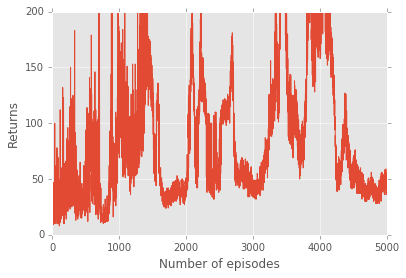

In [88]:
plt.plot(G)
plt.ylabel('Returns')
plt.xlabel('Number of episodes')
plt.savefig("plots/Reinforce_Cartpole_epVsG2")

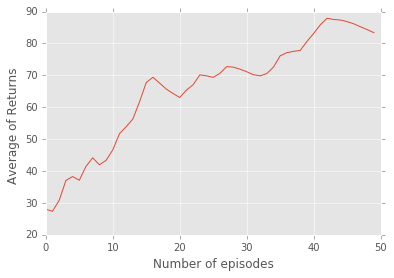

In [89]:
plt.plot(mean_G_all)
plt.ylabel('Average of Returns ')
plt.xlabel('Number of episodes')
plt.savefig("plots/Reinforece_Cartpole_epVsAVG2")

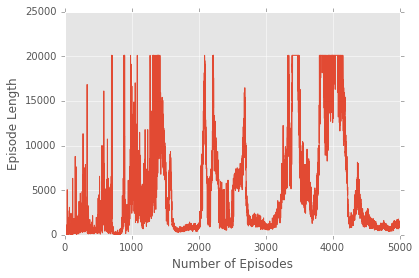

In [90]:
plt.plot(episodes_length)
plt.ylabel('Episode Length')
plt.xlabel('Number of Episodes')
plt.savefig("plots/Reinforece_Cartpole_epVseplength2")

In [91]:
variance=np.std(G)
print(variance)

52.17837844893227
